In [1]:
import yaml
import os
import joblib

In [2]:
# Data wrangling
import pandas as pd
import numpy as np

In [3]:
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight

In [4]:
%run "C:/Users/mjkipsz2/OneDrive - The University of Manchester/Desktop/Pump failure/utils.py"

In [5]:
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline

In [6]:
import optuna
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import f1_score

In [7]:
import mlflow
import mlflow.sklearn
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("pump_failure_prediction")

<Experiment: artifact_location=('file:///c:/Users/mjkipsz2/OneDrive - The University of '
 'Manchester/Desktop/Pump failure/notebook/mlruns/307286651761719792'), creation_time=1734704895170, experiment_id='307286651761719792', last_update_time=1734704895170, lifecycle_stage='active', name='pump_failure_prediction', tags={}>

In [8]:
# Load the configuration file
with open('../config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

# Access the settings
project_folder = config['projectFolder']
df_path = os.path.join(project_folder, config['transformedDataFile'])
df = pd.read_csv(df_path)

# Display the first few rows
df.head()

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Type_High,Type_Low,Type_Medium,Failure_type
0,-0.951417,-0.946356,0.067484,0.283054,-1.695647,0.0,0.0,1.0,No Failure
1,-0.901428,-0.878954,-0.729604,0.634238,-1.648511,0.0,1.0,0.0,No Failure
2,-0.951417,-1.013759,-0.227940,0.945286,-1.617087,0.0,1.0,0.0,No Failure
3,-0.901428,-0.946356,-0.590253,-0.048061,-1.585664,0.0,1.0,0.0,No Failure
4,-0.901428,-0.878954,-0.729604,0.002108,-1.554240,0.0,1.0,0.0,No Failure


In [9]:
# Define features (X) and target variable (y)
X = df.drop('Failure_type', axis=1)  # Features (all columns except 'Failure_type')
y = df['Failure_type']  # Target variable

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Check the shape of the data
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (7978, 8)
Testing data shape: (1995, 8)


In [11]:
# Encode target labels as XGB requires numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [12]:
# Creating pipeline with xgboost classifier and smote
xg_boost_smote = Pipeline(steps=[
    ('smote', SMOTE(random_state=2023)),
    ('model', LGBMClassifier(random_state=2023))
])

# Fit pipeline 
xg_boost_smote.fit(X_train, y_train_encoded)

# Generate Predictions using the correctly fitted pipeline
y_pred = xg_boost_smote.predict(X_test)

# Decode predictions back to original labels (optional)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Evaluate Metrics
metrics = get_metrics(y_test_encoded, y_pred)

# View Results
metrics

c:\Users\mjkipsz2\OneDrive - The University of Manchester\Desktop\Pump failure\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\mjkipsz2\OneDrive - The University of Manchester\Desktop\Pump failure\.venv\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 38535, number of used features: 8
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


{'Accuracy': 0.9729323308270676,
 'Balanced Accuracy': np.float64(0.8068729787998563),
 'Macro Recall': 0.9729323308270676,
 'Macro Precision': 0.9871708567708818,
 'Macro F1': 0.979438394478446,
 'F1 Scores per Class': array([0.89795918, 0.98617992, 0.66666667, 0.79166667, 0.10810811])}

In [13]:
# Creating model with LGBM classifier and balanced class weights

# Compute sample weights for class imbalance
weights = compute_sample_weight(class_weight='balanced', y=y_train_encoded)

# Initialize lgbm classifier
xgb_model = LGBMClassifier(random_state=2023)

# Fit the model with sample weights
xgb_model.fit(X_train, y_train_encoded, sample_weight=weights)

# Generate predictions
y_pred = xgb_model.predict(X_test)

# Evaluate metrics
metrics = get_metrics(y_test_encoded, y_pred)

# View results
metrics

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 7978, number of used features: 8
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


{'Accuracy': 0.9849624060150376,
 'Balanced Accuracy': np.float64(0.7608632770391663),
 'Macro Recall': 0.9849624060150376,
 'Macro Precision': 0.9888446148992893,
 'Macro F1': 0.9865775289956211,
 'F1 Scores per Class': array([0.91666667, 0.99249288, 0.66666667, 0.85714286, 0.125     ])}

In [14]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),  # Number of boosting rounds
        'max_depth': trial.suggest_int('max_depth', 3, 15),  # Maximum tree depth
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # Learning rate
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),  # Number of leaves in one tree
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),  # Minimum data in leaf
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Subsample ratio of the training data
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Feature subsampling
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),  # L2 regularization
    }
    
    # Initialize the LGBMClassifier with the trial's parameters
    model = LGBMClassifier(random_state=2023, **params)

    # Compute sample weights for class imbalance
    weights = compute_sample_weight(class_weight='balanced', y=y_train_encoded)

    # Fit the model with sample weights
    model.fit(X_train, y_train_encoded, sample_weight=weights)

    # Generate predictions
    y_pred = model.predict(X_test)

    # Evaluate the model using F1-score (or any other metric)
    f1 = f1_score(y_test_encoded, y_pred, average='weighted')  # Weighted F1-score for imbalanced data

    return f1  # Optuna will maximize this score

In [15]:
# Create a study object
study = optuna.create_study(direction='maximize')  # We want to maximize F1-score

# Optimize the study
study.optimize(objective, n_trials=20)  # Run 20 trials (you can increase this for better results)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best F1-score:", study.best_value)

[I 2024-12-20 16:43:13,064] A new study created in memory with name: no-name-6b15d6c8-d9e6-48c9-9e21-85072d7e8020


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 7978, number of used features: 8
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-20 16:43:13,913] Trial 0 finished with value: 0.9350918190315105 and parameters: {'n_estimators': 490, 'max_depth': 4, 'learning_rate': 0.036064604167583496, 'num_leaves': 142, 'min_child_samples': 10, 'subsample': 0.89212198449238, 'colsample_bytree': 0.9861687899040266, 'reg_alpha': 9.958900479915638, 'reg_lambda': 2.9904464179132475}. Best is trial 0 with value: 0.9350918190315105.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 7978, number of used features: 8
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-20 16:43:14,316] Trial 1 finished with value: 0.9291704464717474 and parameters: {'n_estimators': 136, 'max_depth': 15, 'learning_rate': 0.01459250666019043, 'num_leaves': 91, 'min_child_samples': 89, 'subsample': 0.5714819941859686, 'colsample_bytree': 0.8206108368723857, 'reg_alpha': 1.9740703587543473, 'reg_lambda': 0.299623755547912}. Best is trial 0 with value: 0.9350918190315105.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 7978, number of used features: 8
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-20 16:43:15,046] Trial 2 finished with value: 0.9632478752641631 and parameters: {'n_estimators': 454, 'max_depth': 7, 'learning_rate': 0.08008088233495239, 'num_leaves': 103, 'min_child_samples': 48, 'subsample': 0.8577732475730631, 'colsample_bytree': 0.8623110648179857, 'reg_alpha': 3.4540137446146266, 'reg_lambda': 3.758376428139163}. Best is trial 2 with value: 0.9632478752641631.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 7978, number of used features: 8
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-20 16:43:15,938] Trial 3 finished with value: 0.9334029665439175 and parameters: {'n_estimators': 370, 'max_depth': 6, 'learning_rate': 0.015470817766446316, 'num_leaves': 147, 'min_child_samples': 93, 'subsample': 0.6927007808525314, 'colsample_bytree': 0.8733838902915658, 'reg_alpha': 6.323701158618682, 'reg_lambda': 8.85000309153479}. Best is trial 2 with value: 0.9632478752641631.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 7978, number of used features: 8
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-20 16:43:17,518] Trial 4 finished with value: 0.9657831108382144 and parameters: {'n_estimators': 445, 'max_depth': 14, 'learning_rate': 0.019317466059049212, 'num_leaves': 32, 'min_child_samples': 47, 'subsample': 0.8954572454444425, 'colsample_bytree': 0.93111328632439, 'reg_alpha': 2.2185618213398217, 'reg_lambda': 3.032578564634435}. Best is trial 4 with value: 0.9657831108382144.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 7978, number of used features: 8
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-20 16:43:17,906] Trial 5 finished with value: 0.9408381334782652 and parameters: {'n_estimators': 297, 'max_depth': 11, 'learning_rate': 0.12360526294803675, 'num_leaves': 82, 'min_child_samples': 95, 'subsample': 0.974650263562006, 'colsample_bytree': 0.8351376241324869, 'reg_alpha': 7.673681048323527, 'reg_lambda': 8.62550812797458}. Best is trial 4 with value: 0.9657831108382144.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-20 16:43:18,257] Trial 6 finished with value: 0.9101650667003256 and parameters: {'n_estimators': 140, 'max_depth': 3, 'learning_rate': 0.01569494119639571, 'num_leaves': 43, 'min_child_samples': 92, 'subsample': 0.6398074324438239, 'colsample_bytree': 0.9325548976538847, 'reg_alpha': 6.349614843568169, 'reg_lambda': 6.774996519526054}. Best is trial 4 with value: 0.9657831108382144.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-20 16:43:18,484] Trial 7 finished with value: 0.9150917110096712 and parameters: {'n_estimators': 92, 'max_depth': 5, 'learning_rate': 0.020716411457378056, 'num_leaves': 81, 'min_child_samples': 25, 'subsample': 0.7474666579384928, 'colsample_bytree': 0.7784918598913924, 'reg_alpha': 8.128768839330709, 'reg_lambda': 4.545346748340685}. Best is trial 4 with value: 0.9657831108382144.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-20 16:43:18,965] Trial 8 finished with value: 0.9367956192074003 and parameters: {'n_estimators': 281, 'max_depth': 3, 'learning_rate': 0.06320374850615532, 'num_leaves': 100, 'min_child_samples': 47, 'subsample': 0.8404836402813205, 'colsample_bytree': 0.5554000603312936, 'reg_alpha': 7.209183770053924, 'reg_lambda': 3.3450269310357728}. Best is trial 4 with value: 0.9657831108382144.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-20 16:43:19,273] Trial 9 finished with value: 0.9139748406602171 and parameters: {'n_estimators': 95, 'max_depth': 8, 'learning_rate': 0.011504905563669407, 'num_leaves': 95, 'min_child_samples': 50, 'subsample': 0.9553351537229382, 'colsample_bytree': 0.8119546850481452, 'reg_alpha': 1.5928798955899626, 'reg_lambda': 7.687086694730004}. Best is trial 4 with value: 0.9657831108382144.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-20 16:43:19,870] Trial 10 finished with value: 0.9828410399853503 and parameters: {'n_estimators': 384, 'max_depth': 15, 'learning_rate': 0.2755379746144626, 'num_leaves': 23, 'min_child_samples': 70, 'subsample': 0.5075836758534784, 'colsample_bytree': 0.6420386591328516, 'reg_alpha': 0.46888002464191114, 'reg_lambda': 0.7837685972150688}. Best is trial 10 with value: 0.9828410399853503.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 7978, number of used features: 8
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-20 16:43:20,786] Trial 11 finished with value: 0.9840922698379434 and parameters: {'n_estimators': 397, 'max_depth': 15, 'learning_rate': 0.293135647929759, 'num_leaves': 20, 'min_child_samples': 72, 'subsample': 0.5513100612149626, 'colsample_bytree': 0.6484469037452059, 'reg_alpha': 0.03646611161596924, 'reg_lambda': 0.9942987347823288}. Best is trial 11 with value: 0.9840922698379434.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 7978, number of used features: 8
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-20 16:43:21,233] Trial 12 finished with value: 0.9818229859093432 and parameters: {'n_estimators': 374, 'max_depth': 12, 'learning_rate': 0.29665463209229515, 'num_leaves': 22, 'min_child_samples': 70, 'subsample': 0.5330498849797842, 'colsample_bytree': 0.6432680663220163, 'reg_alpha': 0.2105352092846246, 'reg_lambda': 0.007588986638299655}. Best is trial 11 with value: 0.9840922698379434.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wit

[I 2024-12-20 16:43:21,952] Trial 13 finished with value: 0.9836942403578571 and parameters: {'n_estimators': 372, 'max_depth': 13, 'learning_rate': 0.28583217078521106, 'num_leaves': 54, 'min_child_samples': 74, 'subsample': 0.503246293640329, 'colsample_bytree': 0.6829710837514864, 'reg_alpha': 0.2626432237234399, 'reg_lambda': 1.1746814600347342}. Best is trial 11 with value: 0.9840922698379434.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 7978, number of used features: 8
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-20 16:43:22,353] Trial 14 finished with value: 0.9657304751218156 and parameters: {'n_estimators': 331, 'max_depth': 12, 'learning_rate': 0.16110714209687108, 'num_leaves': 54, 'min_child_samples': 72, 'subsample': 0.6033109182102259, 'colsample_bytree': 0.7026721578790814, 'reg_alpha': 3.645962022224354, 'reg_lambda': 1.5409225792192536}. Best is trial 11 with value: 0.9840922698379434.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-12-20 16:43:22,738] Trial 15 finished with value: 0.9573233854201746 and parameters: {'n_estimators': 213, 'max_depth': 10, 'learning_rate': 0.17204258945834874, 'num_leaves': 60, 'min_child_samples': 79, 'subsample': 0.6576289844991865, 'colsample_bytree': 0.5022406145866094, 'reg_alpha': 4.383419167156223, 'reg_lambda': 1.858970732228209}. Best is trial 11 with value: 0.9840922698379434.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-20 16:43:23,382] Trial 16 finished with value: 0.9822343430450159 and parameters: {'n_estimators': 205, 'max_depth': 13, 'learning_rate': 0.10836426607652769, 'num_leaves': 64, 'min_child_samples': 59, 'subsample': 0.502336794849783, 'colsample_bytree': 0.7076423396725545, 'reg_alpha': 0.3006902318336282, 'reg_lambda': 5.754686563172016}. Best is trial 11 with value: 0.9840922698379434.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 7978, number of used features: 8
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-20 16:43:24,032] Trial 17 finished with value: 0.9791753221214509 and parameters: {'n_estimators': 420, 'max_depth': 9, 'learning_rate': 0.22589042677963037, 'num_leaves': 41, 'min_child_samples': 61, 'subsample': 0.5729342897757451, 'colsample_bytree': 0.6152045572449515, 'reg_alpha': 1.231329320510862, 'reg_lambda': 1.7891427763667669}. Best is trial 11 with value: 0.9840922698379434.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-20 16:43:25,016] Trial 18 finished with value: 0.9610346569580815 and parameters: {'n_estimators': 326, 'max_depth': 13, 'learning_rate': 0.037559611678431415, 'num_leaves': 116, 'min_child_samples': 83, 'subsample': 0.7397160010391077, 'colsample_bytree': 0.7114105059813178, 'reg_alpha': 3.047271029408991, 'reg_lambda': 5.3158134813379805}. Best is trial 11 with value: 0.9840922698379434.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 7978, number of used features: 8
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2024-12-20 16:43:25,677] Trial 19 finished with value: 0.954424840745604 and parameters: {'n_estimators': 499, 'max_depth': 14, 'learning_rate': 0.19906651231403863, 'num_leaves': 73, 'min_child_samples': 34, 'subsample': 0.5589586221088527, 'colsample_bytree': 0.5902976499471234, 'reg_alpha': 5.028035829417069, 'reg_lambda': 2.216042161052613}. Best is trial 11 with value: 0.9840922698379434.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [16]:
# Extract the best hyperparameters
best_params = study.best_params

# Train the final model with the best hyperparameters
final_model = LGBMClassifier(random_state=2023, **best_params)

# Compute sample weights again
weights = compute_sample_weight(class_weight='balanced', y=y_train_encoded)

# Start an MLflow run
with mlflow.start_run(run_name="LGBM_classification_run"):

    # Log the best hyperparameters
    mlflow.log_params(best_params)
    
    # Fit the final model
    final_model.fit(X_train, y_train_encoded, sample_weight=weights)
    
    # Generate predictions
    y_pred = final_model.predict(X_test)
    
    # Evaluate metrics
    metrics = get_metrics(y_test_encoded, y_pred)
    
    # Remove 'F1 Scores per Class' from metrics
    if 'F1 Scores per Class' in metrics:
        del metrics['F1 Scores per Class']
    
    # Log metrics
    mlflow.log_metrics(metrics)
    
    # Optionally, log the final model
    mlflow.sklearn.log_model(final_model, "LGBM_classifier")

# View results
metrics

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 7978, number of used features: 8
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

2024/12/20 16:43:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


{'Accuracy': 0.9819548872180451,
 'Balanced Accuracy': np.float64(0.7516510959396335),
 'Macro Recall': 0.9819548872180451,
 'Macro Precision': 0.9866433289526011,
 'Macro F1': 0.9840922698379434}

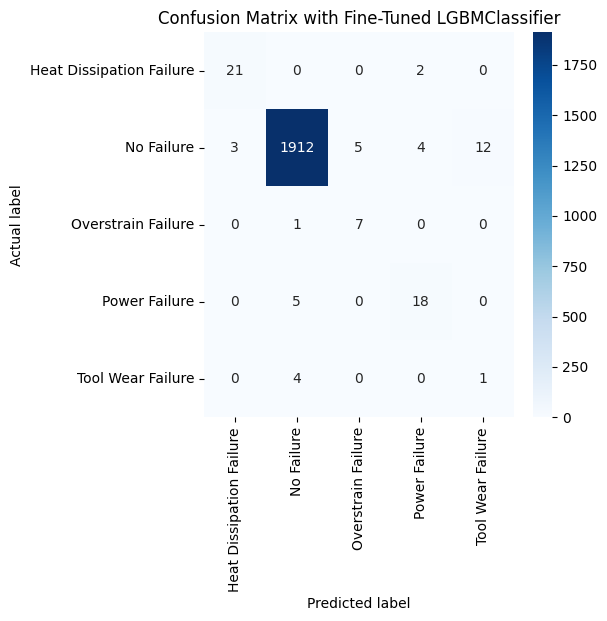

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Decode predictions if necessary
# Assuming y_test contains string labels and y_pred contains numeric labels
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_decoded)

# Plot the confusion matrix
plt.figure(figsize=(5, 5))  # Larger figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  # Use 'd' to format numbers as integers
            xticklabels=np.unique(y_test), 
            yticklabels=np.unique(y_test))  # Ensure labels match y_test
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix with Fine-Tuned LGBMClassifier')
plt.show()

In [18]:
joblib.dump(final_model, 'C:/Users/mjkipsz2/OneDrive - The University of Manchester/Desktop/Pump failure/model/final_model.joblib')

['C:/Users/mjkipsz2/OneDrive - The University of Manchester/Desktop/Pump failure/model/final_model.joblib']

In [19]:
#from sklearn.preprocessing import OneHotEncoder
#import joblib

#df_train=pd.read_csv('C:/Users/mjkipsz2/OneDrive - The University of Manchester/Desktop/Pump failure/data/clean_data.csv')

# Initialize and fit the encoder during training
#encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Use sparse_output instead of sparse
#encoded_type = encoder.fit_transform(df_train[['Type']])  # Fit on the 'Type' column

# Save the encoder for later use
#joblib.dump(encoder, 'C:/Users/mjkipsz2/OneDrive - The University of Manchester/Desktop/Pump failure/model/onehot_encoder.pkl')